# 001 Friedel Pairs Labeling - Test
Find Friedel pairs in a single s3DXRd dataset. If you need to process a list of datasets, use this notebook to test which parameters work the best for the search, before running the batch process (001_Friedel_Pairs_batch)

### load packages

In [ ]:
# general modules
import os, sys
import h5py
import pylab as pl
import numpy as np

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.sparseframe
import ImageD11.blobcorrector
import ImageD11.columnfile


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
# Not yet installable with pip, just copy + paste the files into your working folder 
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
    
from pf_3dxrd import utils, friedel_pairs, crystal_structure

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Load data

In [1]:
def load_data(dsname, parfile, input_format = 'peaktable', return_2D_peaks=False):
    """ 
    load data from peakfile or peaktable 
    
    Args:
    ----------
    dsname (str) : dataset name
    parfile (str): parameter file name
    input_format (str) : either 'peaktable' or 'peakfile'. Control whether data is loaded from an ImageD11 peak table or from a simple peakfile 
    detector (str) : detector type used for data acquisition. eiger or frelon. Default if eiger (nanofocus station at ID11)
    return_2D_peaks (bool): returns 2D peaks instead of 3D peaks (merged in omega) are returned. Only relevant for data loaded from a peak table
                            default is False
    
    Returns:
    cf : ImageD11 columnfile
    ds : ImageD11 dataset
    """
    ####################################
    assert input_format in ['peakfile', 'peaktable'], 'input_format must be either "peakfile" or "peaktable" '
    
    # paths
    ####################################
    if input_format == 'peaktable':
        pksfile = os.path.join(data_dir, dsname+'_pkst.h5')
        dsfile  = pksfile.replace('pkst','dataset')
    else:
        pksfile = os.path.join(data_dir, dsname+'_pks.h5') 
        dsfile  = pksfile.replace('pks','dataset')
   
    
    # load ds file and peaks dictionary
    ####################################
    ds = ImageD11.sinograms.dataset.load(dsfile)

    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.1f}')
        
    print('==============================')
        
    if input_format == 'peakfile':
        print('loading peakfile...')
        pks = ImageD11.columnfile.columnfile(pksfile)
        pkd = {t:pks.getcolumn(t) for t in pks.titles}
         
    else:
        print('loading peaks from peak table...')
        pkst = ImageD11.sinograms.properties.pks_table.load(pksfile)
        
        print('merging peaks...')
        if return_2D_peaks:      
            pkd = pkst.pk2d( ds.omega, ds.dty )         # for 2D peaks
        else:
            pkd = pkst.pk2dmerge( ds.omega, ds.dty )  # for 3D peaks
            
    cf = ImageD11.columnfile.colfile_from_dict(pkd)
    print(f'loaded peakfile: nrows = {cf.nrows}')
    utils.get_colf_size(cf)
    
    return cf, ds


In [19]:
# define paths
data_dir = 'data'

dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'
splinefile = 'data/frelon21_mar16.spline'


# load data
cf, ds = load_data(dsname, parfile, return_2D_peaks=False, input_format='peakfile')

print(cf.titles)

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.0
n_ostep: 450.0
ymin: -2.7
ymax: 2.7
ystep: 0.1
omin: 0.0
omax: 360.0
ostep: 0.8
loading peakfile...
Reading your columnfile in hdf format
loaded peakfile: nrows = 4104546
Total size =  109.60 MB
['omega', 's_raw', 'f_raw', 'sum_intensity', 'spot3d_id', 'dty', 'number_of_pixels']


### Distortion correction

cf contains raw data columns f_raw, s_raw with raw peak coordinates. These coordinates need to be corrected for detector distortion. Different methods exist depending on the detector used for data acquisition. For the eiger detector of ID11 (nanofocus station), pre-computed distorsion images dxfile, dyfiles are provided, which allow fast distortion correction. For the frelon detector (3DXRD station), a splinefile is provided, from which a pixel lookup table is made, which gives the dx,dy correction for each pixel. 

In [20]:
def correct_distortion_eiger( cf, parfile,
              dxfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf",
              dyfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"):
    
    """ 
    FOR EIGER DATA. Apply detector distortion correction for eiger data, using pre-computed disortion files. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    dxfile, dyfile : detector distortion. Default files are valid for the eiger detector on the nanofocus station at ID11 
    """
    
    spat = ImageD11.blobcorrector.eiger_spatial( dxfile = dxfile, dyfile = dyfile )
    cf = ImageD11.columnfile.colfile_from_dict( spat( {t:cf.getcolumn(t) for t in cf.titles()} ) )
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    return cf


def correct_distortion_frelon( cf, parfile, splinefile):
    """ 
    FOR FRELON DATA. Apply detector distortion correction using a pixel look up table computed from a splinefile. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    splinefile    : detector distortion splinefile
    detector_dim  : (X,Y) detector dimensions  
    """
    
    spat = ImageD11.blobcorrector.correctorclass(splinefile)
    
    # make pixel_lut  + substract xy grid coordinate (i,j) to keep only dx and dy arrays.
    spat.make_pixel_lut(spat.dim)
    i, j = np.mgrid[ 0:spat.dim[0], 0:spat.dim[1] ]
    dx = spat.pixel_lut[0] - i
    dy = spat.pixel_lut[1] - j
    
    # get integer pixel index (si,fi) of each peak
    si = np.round(cf['s_raw']).astype(int)
    fi = np.round(cf['f_raw']).astype(int)
    
    # apply dx dy correction on s_raw / f_raw
    sc = (dx[ si, fi ] + cf.s_raw).astype(np.float32)
    fc = (dy[ si, fi ] + cf.f_raw).astype(np.float32)
    
    # add corrected arrays as new columns
    cf.addcolumn(sc, 'sc')
    cf.addcolumn(fc, 'fc')
    
    # load parameters and update geometry
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    return cf

In [21]:
# detector correction distorsion with frelon data
cf = correct_distortion_frelon( cf, parfile, splinefile)

# detector correction distorsion with eiger data
#cf = correct_distortion_eiger(cf, parfile)

### Pre-processing
clean up a bit the peakfile to remove weak peaks before looking for Friedel pairs

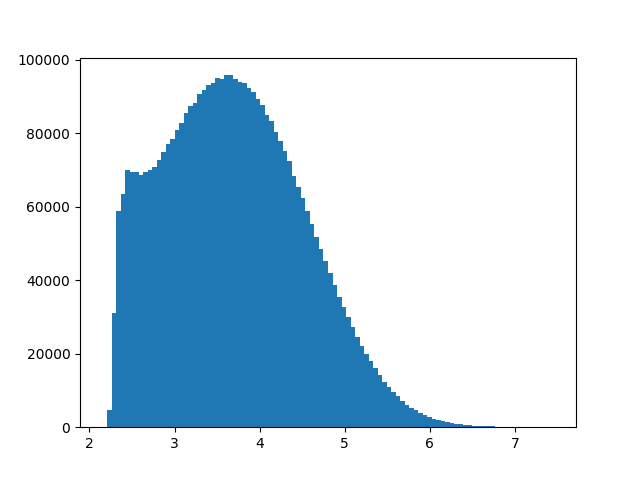

In [22]:
# look at distribution of peak intensity + nb of pixels
pl.figure()
pl.hist(np.log10(cf.sum_intensity),100);

In [23]:
# filter data
cf.filter(cf.sum_intensity>15)
cf.filter(cf.number_of_pixels>3)   # column title might be 'Number_of_pixels' depending on how data have been pre-processed

cf.nrows

3863533

Friedel pairs match is found between peaks from symmetric scans (+dty;-dty) acquired at equal distance from the rotation center. Form pairs of dty scans and check data is ok

In [24]:
# form dty pairs: pairs of (dty,-dty) scans which should contain symmetric information
friedel_pairs.form_y_pairs(cf, ds, disp=True)

dty_center =  -0.00  on bin n° 54
dty pairs: 
-0.0000 ; -0.0000
0.0500 ; -0.0500
0.1000 ; -0.1000
0.1500 ; -0.1500
0.2000 ; -0.2000
0.2500 ; -0.2500
0.3000 ; -0.3000
0.3500 ; -0.3500
0.4000 ; -0.4000
0.4500 ; -0.4500
0.5000 ; -0.5000
0.5500 ; -0.5500
0.6000 ; -0.6000
0.6500 ; -0.6500
0.7000 ; -0.7000
0.7500 ; -0.7500
0.8000 ; -0.8000
0.8500 ; -0.8500
0.9000 ; -0.9000
0.9500 ; -0.9500
1.0000 ; -1.0000
1.0500 ; -1.0500
1.1000 ; -1.1000
1.1500 ; -1.1500
1.2000 ; -1.2000
1.2500 ; -1.2500
1.3000 ; -1.3000
1.3500 ; -1.3500
1.4000 ; -1.4000
1.4500 ; -1.4500
1.5000 ; -1.5000
1.5500 ; -1.5500
1.6000 ; -1.6000
1.6500 ; -1.6500
1.7000 ; -1.7000
1.7500 ; -1.7500
1.8000 ; -1.8000
1.8500 ; -1.8500
1.9000 ; -1.9000
1.9500 ; -1.9500
2.0000 ; -2.0000
2.0500 ; -2.0500
2.1000 ; -2.1000
2.1500 ; -2.1500
2.2000 ; -2.2000
2.2500 ; -2.2500
2.3000 ; -2.3000
2.3500 ; -2.3500
2.4000 ; -2.4000
2.4500 ; -2.4500
2.5000 ; -2.5000
2.5500 ; -2.5500
2.6000 ; -2.6000
2.6500 ; -2.6500
2.7000 ; -2.7000


dty pairs should have roughly the same number of peaks assigned. If not, the sample is certainly not very well aligned on the rotation center (not a big deal), or maybe it has moved during scanning (more problematic)

sorting peakfile by dty scans...
computing stats for each scan...


55it [00:00, 19134.60it/s]


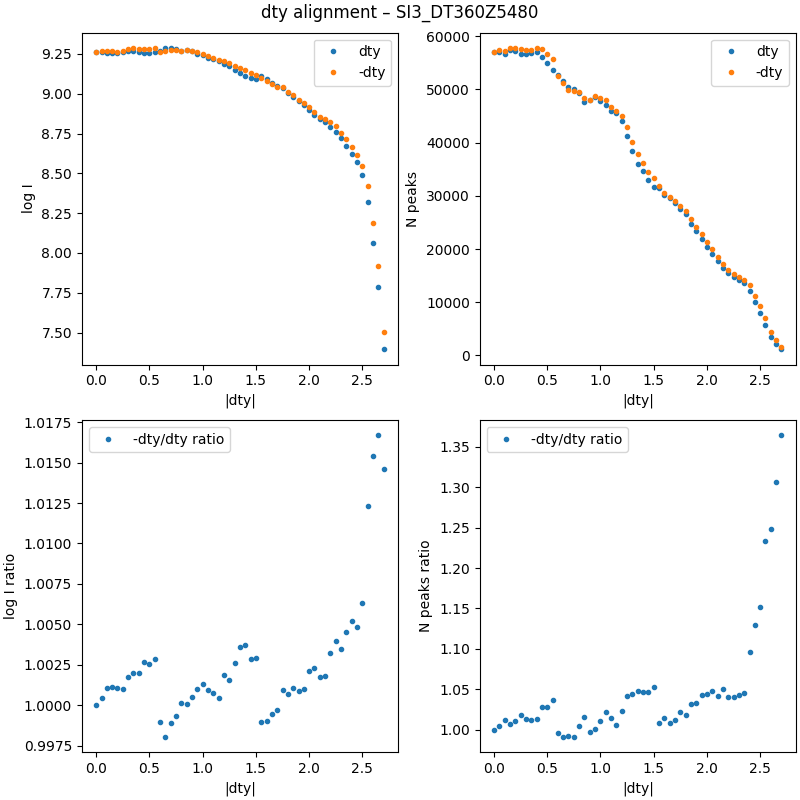

In [25]:
# check symmetry of intensity and number of pixels 
friedel_pairs.check_y_symmetry(cf, ds, saveplot=False)

### Friedel pair labeling

Find Fridel pairs on one pair of scans, to see how it looks. The two paremeters dist_max and dist_step control the distance threshold applied for nearest-neighbor search. At each iteration, the distance threshold is increased of dist_step, until the value dist_max is reached. This distance is expressed in a 4D space formed using two-theta, eta, omega, intensity, each rescaled and normalized to a value between zero and 1. fp_dist is the total euclidian distance between two peaks in a pair in the 4D search space. If doplot is True, histograms of the 4D Euclidian distance + distance along each dimension (expressed in meaningful angle or value) are plotted

sorting peakfile by dty scans...
3018 pairs kept out of  57045  possible matches
10311 pairs kept out of  54027  possible matches
7751 pairs kept out of  43716  possible matches
5759 pairs kept out of  35965  possible matches
4538 pairs kept out of  30206  possible matches
3292 pairs kept out of  25668  possible matches
2629 pairs kept out of  22376  possible matches
1891 pairs kept out of  19747  possible matches
2004 pairs kept out of  17856  possible matches
1527 pairs kept out of  15852  possible matches
1178 pairs kept out of  14325  possible matches
962 pairs kept out of  13147  possible matches
737 pairs kept out of  12185  possible matches
716 pairs kept out of  11448  possible matches
536 pairs kept out of  10732  possible matches
Friedel pair matching Completed.
N pairs = 46849 out of 57045 possible candidates
Fraction of peaks matched = 0.82
Fraction of intensity matched = 0.94
dstep_max = 1.500


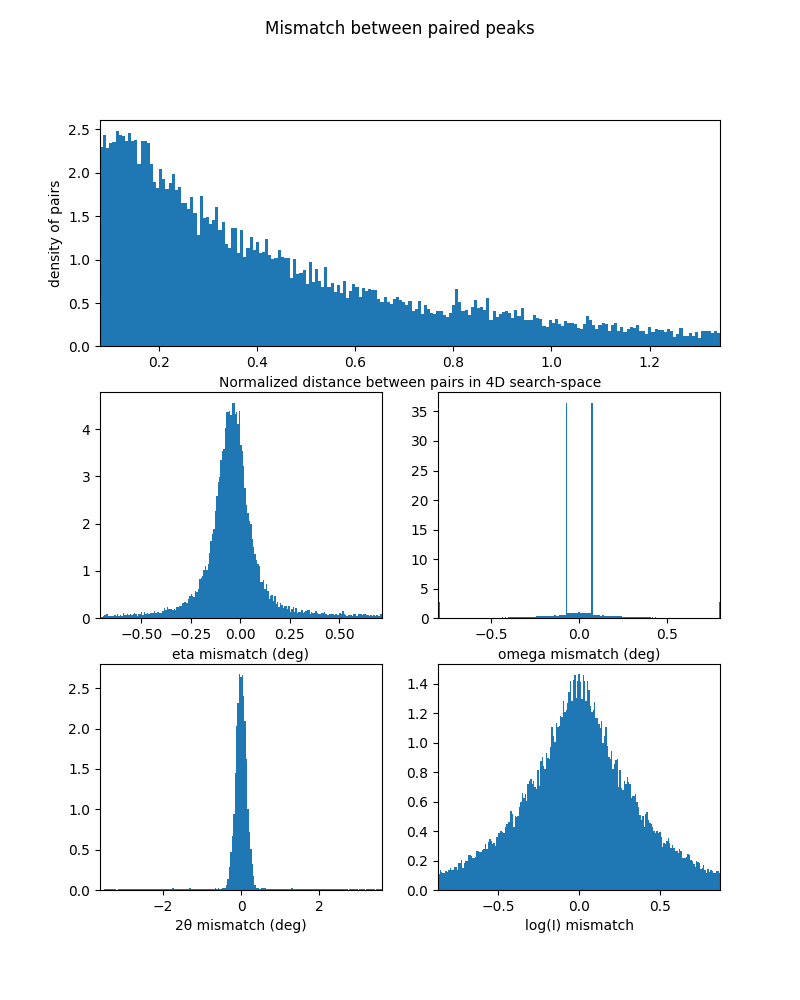

In [13]:
# select peaks from a pair
c1, c2 = friedel_pairs.select_y_pair(cf, ds, pair_id = 0)

# friedel pair search. let's try first with these values
cp = friedel_pairs.label_friedel_pairs(c1,c2,
                                  dist_max = 1.5,
                                  dist_step = 0.1,
                                  mtth = 1,
                                  mI = 1,
                                  verbose=True,
                                  doplot=True)

Try to adjust dist_threshold and dist_max until Fridel pair matching looks good. Once you are satisfied with your parameters, run Friedelpair search on the whole dataset using the function find_all_pairs. It iterates label_friedel_pairs on all ypairs in the dataset and then merges all outputs in a single peakfile.

Friedel pair search...


100%|██████████| 55/55 [00:29<00:00,  1.87it/s]


Updating Friedel pair labels


100%|██████████| 54/54 [00:00<00:00, 470.54it/s]


Merging peakfiles...
Friedel pair matching Completed.
N pairs =  1477608
Fraction of peaks matched = 0.76
Fraction of total intensity matched = 0.92


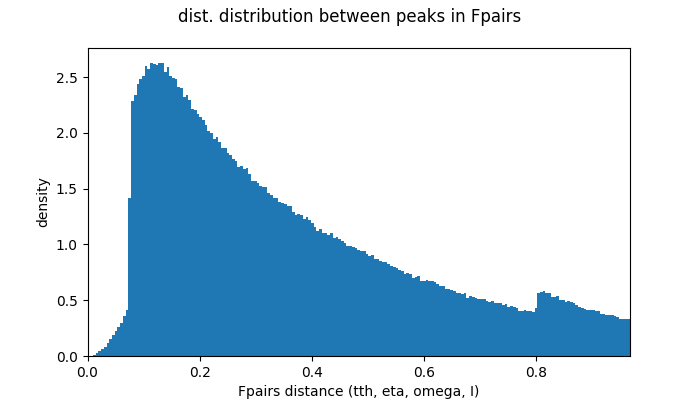

In [26]:
out = friedel_pairs.find_all_pairs(cf,
                                   ds,
                                   dist_max=1.,
                                   dist_step=0.1,
                                   mI=1/5,
                                   mtth=1)


cf_paired, fp_labels, stats = friedel_pairs.merge_outputs(out, cf, doplot=True)

In [15]:
# Plot the distribution of mismatch between Friedel pair along each dimension: eta, omega, tth, sumI. split between low fp_dist and large fp_dist subsets

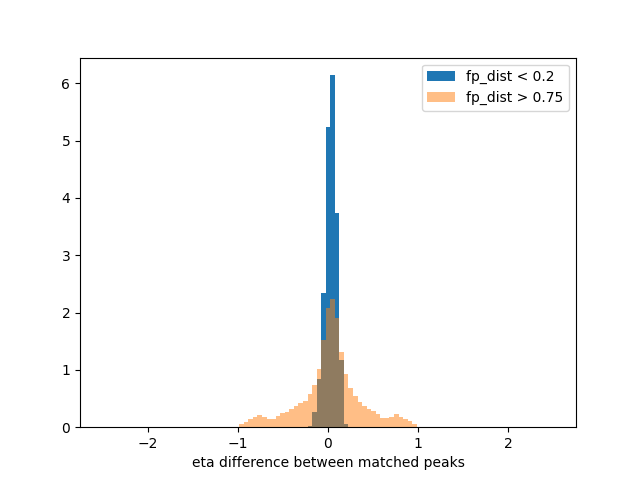

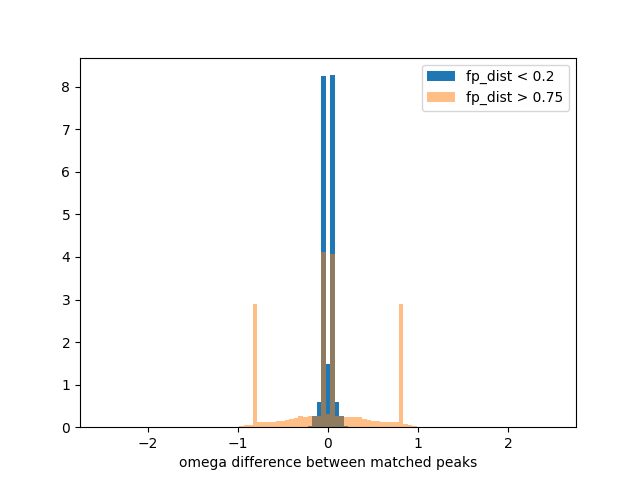

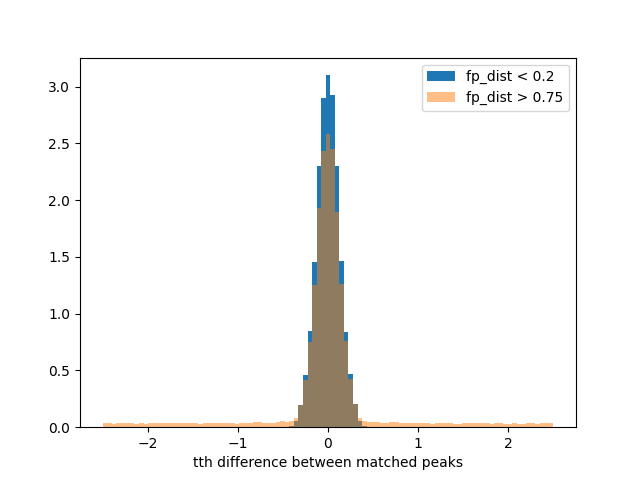

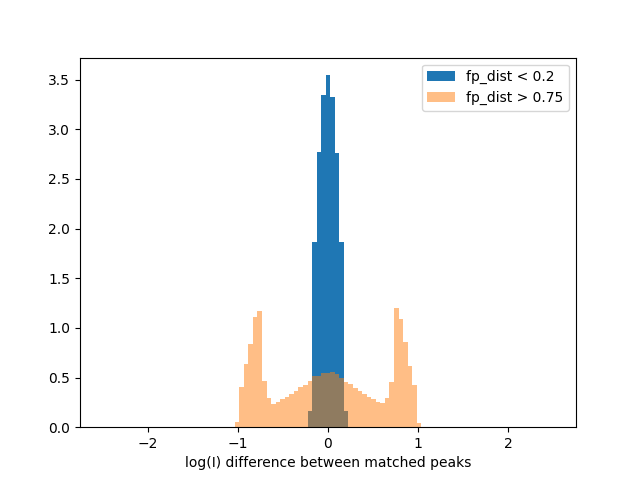

In [27]:
c1, c2 = friedel_pairs.split_fpairs(cf_paired)
dlow, dhigh = 0.2, 0.75
m = c1.fp_dist < dlow
m2 = c1.fp_dist > dhigh


pl.figure()
pl.hist(c1.eta[m]%360 - (180-c2.eta[m])%360,bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.eta[m2]%360 - (180-c2.eta[m2])%360,bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('eta difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(c1.omega[m]%360 - (180+c2.omega[m])%360,bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.omega[m2]%360 - (180+c2.omega[m2])%360,bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('omega difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(c1.tth[m] - (c2.tth[m]),bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.tth[m2] - (c2.tth[m2]),bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('tth difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(np.log10(c1.sum_intensity[m]) - np.log10(c2.sum_intensity[m]),bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(np.log10(c1.sum_intensity[m2]) - np.log10(c2.sum_intensity[m2]),bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('log(I) difference between matched peaks')
pl.legend()


In [29]:
# filter out peaks with fp_dist too large (dodgy)
cf_paired.filter(cf_paired.fp_dist < 0.75)

### Geometry correction
correct 2θ angle and relocates peaks in sample space


In [31]:
# use measured tth from both peak in each pair to find the offset-corrected two-theta angle + relocate peak sources in the sample 
friedel_pairs.update_geometry_s3dxrd(cf_paired, ds, update_gvecs=True) 

Text(0, 0.5, 'pdf')

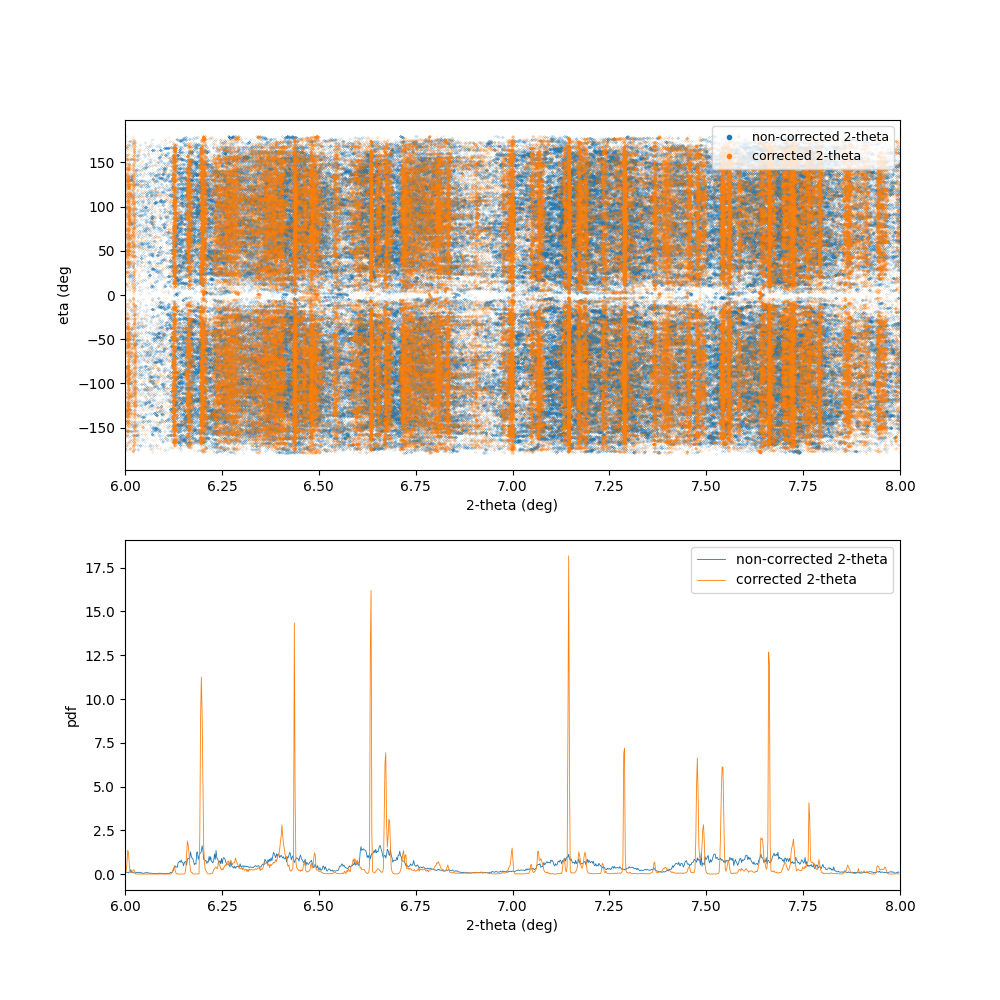

In [20]:
# plot 2-theta vs. eta for corrected vs non-corrected tth on a subset of the two-theta range
tthmin, tthmax = 6,8

fig = pl.figure(figsize=(10,10))
fig.add_subplot(211)
pl.plot(cf_paired.tth, cf_paired.eta, '.', ms = .2, label='non-corrected 2-theta') 
pl.plot(cf_paired.tthc, cf_paired.eta, '.', ms=.2, label='corrected 2-theta')
pl.xlabel('2-theta (deg)')
pl.ylabel('eta (deg')
pl.xlim(tthmin, tthmax)
pl.legend(markerscale=30, loc='upper right', fontsize=9) 

# 2-theta histogram for corrected vs non-corrected peaks
fig.add_subplot(212)
h,b,_ = utils.compute_tth_histogram(cf_paired, use_tthc = False, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                    uself = True, doplot=False, density=True)
hc,bc,_ = utils.compute_tth_histogram(cf_paired, use_tthc = True, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                      uself = True, doplot=False, density=True)

pl.plot(b,h,'-', lw=.6, label='non-corrected 2-theta')
pl.plot(bc,hc,'-',lw=.6, label='corrected 2-theta')
pl.legend()
pl.xlim(tthmin, tthmax)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')

#### Comparison with computed hkl rings

compare hkl ring positions with those computed from a list of known crystal structures

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: orthoclase, phase_id: 1, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 2, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]
CS: biotite, phase_id: 3, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: magnetite, phase_id: 4, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]
Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 15
 ---X-Ray Setti

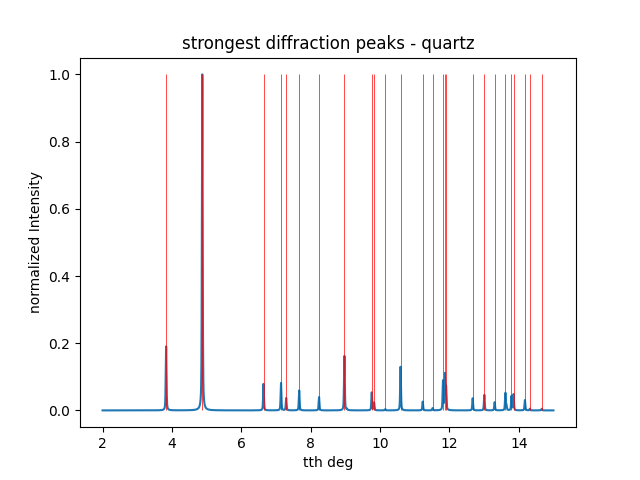

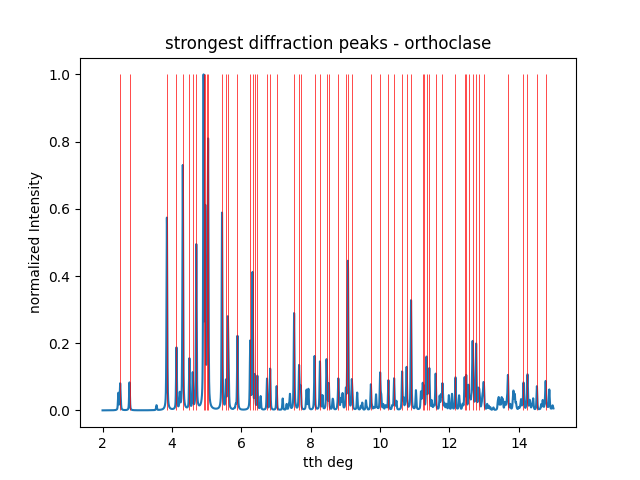

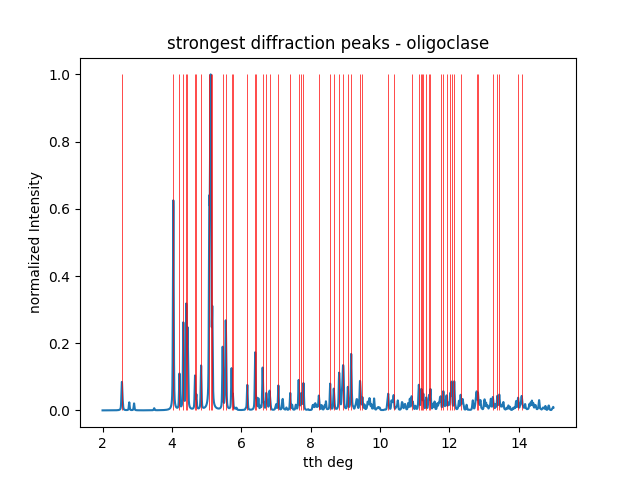

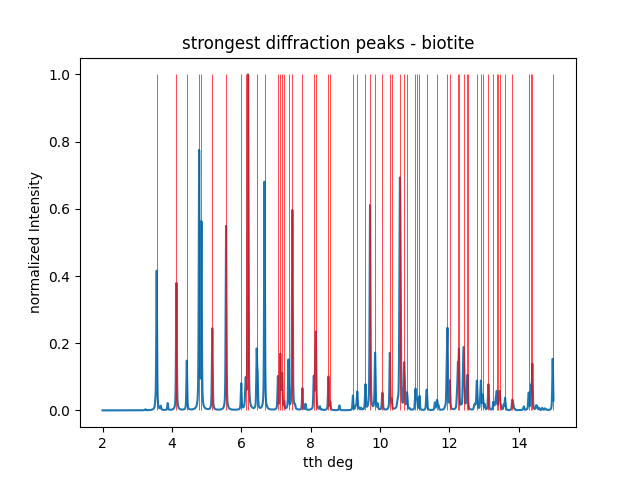

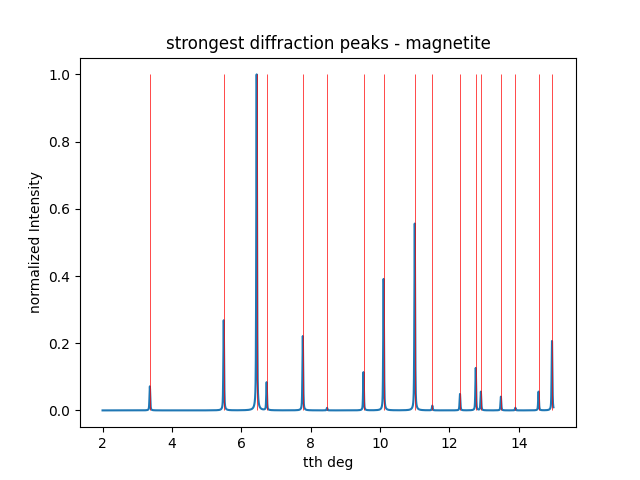

In [21]:
# define a dictionary with all  phases. Here we assume that we already know what are the phases in the sample, but it might be something we want to determine as well
phase_names = ['quartz','orthoclase', 'oligoclase', 'biotite', 'magnetite']
phase_dict = {}

for i,p in enumerate(phase_names):
    cs = crystal_structure.load_CS_from_cif(cif_path = f'cif/{p}.cif', name=p, pid=i)
    print(cs)
    phase_dict[p] = cs
    
    
wl = cf.parameters.get('wavelength')

# compute theoretical 2θ rings: compute a simulated powder spectrum, and then we run a peaksearch on this spectrum to find the N-strongest peaks.
# This allows to retain only the most significant peaks, and not care about all the numerous, very low intensity peaks which theoretically exist but 
#are practically barely visible.

for cs in phase_dict.values():
    cs.compute_powder_spec(wl, min_tth=2, max_tth=15, doplot=False)
    cs.find_strongest_peaks(Imin=0.001, prominence=0.001, Nmax=60, doplot=True)

Now we can replot the data with these theoretical peaks

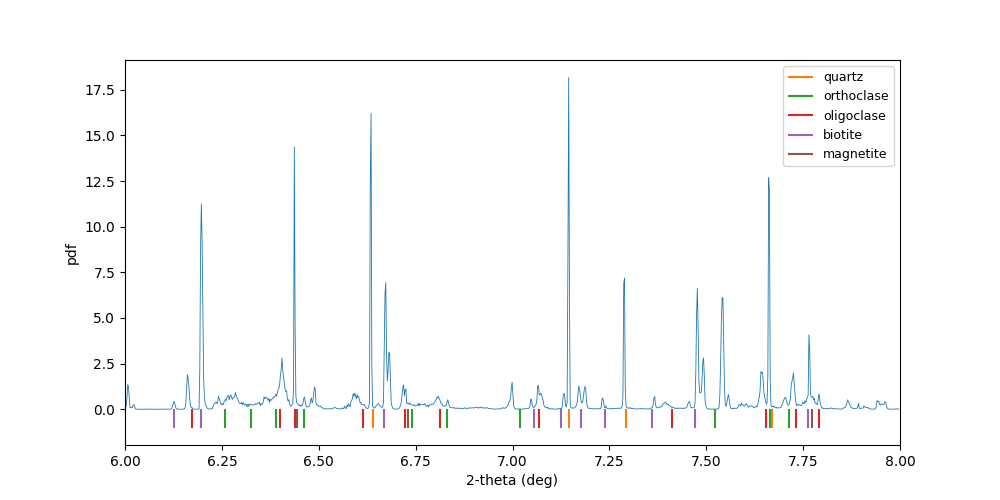

In [22]:
# replot 2θ vs η and add computed hkl ring positions for each phase
colors = pl.matplotlib.cm.tab10.colors

pl.figure(figsize=(10,5))
pl.plot(bc,hc, '-', lw=.6)

for p,cs in phase_dict.items():
    pl.vlines(cs.strong_peaks[0], -1,0, colors = colors[cs.phase_id+1], label=p)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')
pl.xlim(tthmin, tthmax)

pl.legend(loc='upper right', fontsize=9) 

### Sample reconstruction
Reconstruct an image of the sample by mapping the total intensity of diffraction peaks reprojected in sample space

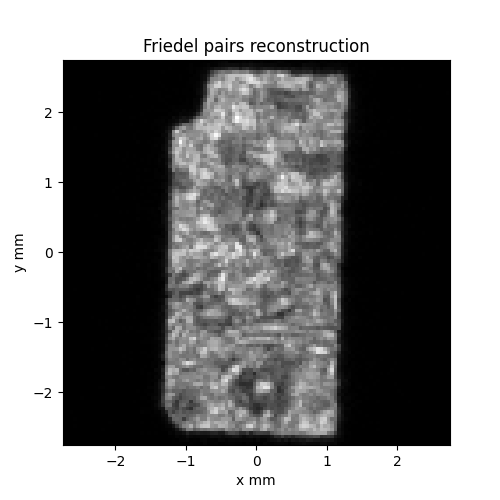

In [23]:
# plot sample reconstruction
kw = {'cmap':'Greys_r'}

utils.friedel_recon(cf_paired,
                    xbins = ds.ybinedges,
                    ybins = ds.ybinedges,
                    doplot=True,
                    mask = None,
                    weight_by_intensity=True,
                    norm = True,
                    **kw );


In [24]:
# filter out peaks outside the ROI, to keep only portions of the map with complete data
cf_paired.filter(cf_paired.r_dist <= ds.ybinedges.max())

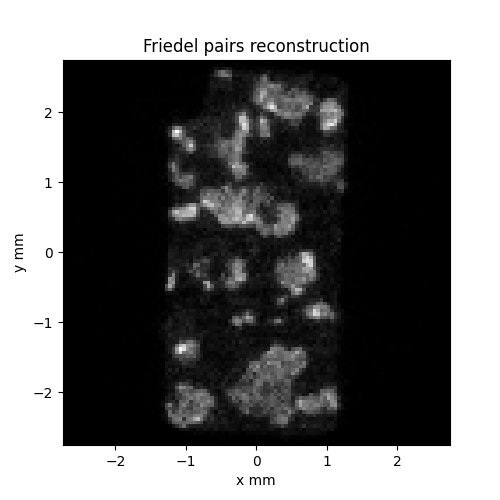

In [25]:
# computereconstruction using only quartz peaks
mask_qtz = utils.select_tth_rings(cf_paired, phase_dict['quartz'].strong_peaks[0][:10], tth_tol=0.02, tth_max=15, is_sorted=False)
kw = {'cmap':'Greys_r'}   # keyword arg to pass to plot function

# plot reconstruction for quartz peaks only
utils.friedel_recon(cf_paired,
                    xbins = ds.ybinedges,
                    ybins = ds.ybinedges,
                    doplot=True,
                    mask = mask_qtz,
                    weight_by_intensity=True,
                    norm = True,
                    **kw );

### save peakfile

In [94]:
# save data. The 'minimal' save mode means that only the necessary data columns are kept. All data that can be recomputed from other columns are dropped.
utils.colf_to_hdf(cf_paired, os.path.join(data_dir, dsname+'_pks_p.h5'), save_mode='minimal')